The focus here is to pull proteomics data from an xlsx file, attempt to dimensionally reduce using pca, ica, umap, pls-da proteomics data from multiple samples (experiments).  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import shapiro, anderson, norm

import umap as U 


The following section is specific for this dataset, this part (data management and tranformation) will likely always be custom for each dataset, however, it can also be the most time consuming 

In [3]:
df = pd.read_excel(r'C:\Users\uqkmuroi\Desktop\Van3_results.xlsx', header = 0)

# as there are many missing columns, and some columns with missing values, we remake columns by specifying their excel equivalent
#I chose to remove any columns with no values, and columns with many missing values
columns_prot = df.iloc[:,
    list(range(183,202)) + # GB to GT
    [206] + # GY
    list(range(209, 214)) + # HB to HF
    list(range(216, 225)) + # HI to HQ
    [226] + # HS
    list(range(228, 237))] # HU to IC

# we also want the UQ strain column as it helps group the rows by experiments (since we're tryin to extract one value from each experiment)
column_strain = df['UQ Strain']

# we combine the two column sets from above
grouped = pd.concat([column_strain, columns_prot], axis=1)

# group by uq strain
grouped = grouped.groupby('UQ Strain')

# this extacts the max value (which is equivalent to the only value per experiment)
group = grouped.max()

# remove the last row as it is Nan 
# group = group.iloc[:-1]

# actually since the last row is the reference, I will change them to 1.0 
group.iloc[-1] = 1.0
print (group)
print(group.shape)

               SAH1      MET6      SAM2      SAM1       ADOI       SER3  \
UQ Strain                                                                 
VAN_011    0.476754  0.726056  8.390562  3.466260   0.826203   0.332212   
VAN_022    0.501503  0.658658  0.833097  1.069050   0.899388   2.937712   
VAN_024    0.489304  0.776491  0.848666  1.006409   1.223536   0.015000   
VAN_034    0.518499  0.560981  0.806098  0.900420   0.705531  38.200194   
VAN_035    0.563034  0.680219  0.961508  0.946449   0.747693  30.411039   
...             ...       ...       ...       ...        ...        ...   
VAN_391    4.271964  3.200832  3.767812  2.142580   1.235859   1.388874   
VAN_392    0.715643  1.176335  1.154362  1.119098   1.147058  55.464613   
VAN_393    0.731537  1.676646  1.641193  1.302600  22.974646   2.837416   
VAN_396    0.879216  0.952300  8.880651  4.468680   0.990007   1.930996   
VAN_REF7   1.000000  1.000000  1.000000  1.000000   1.000000   1.000000   

                SER1    

Since it's not always easy to tell, the below code will tell you if there are any NaNs remaining in the dataset

In [29]:
nan_count = group.isna().sum()

print (nan_count)

SAH1     0
MET6     0
SAM2     0
SAM1     0
ADOI     0
SER3     1
SER1     0
SER2     1
SHM2     0
GCV1     0
GCV2     0
GCV3     0
LPD1     0
MET13    0
FDH1     2
ADE3     0
MIS1     0
SNZ1     0
MET7     0
CBF1     1
CYS4     0
CYS3     0
HOM3     0
HOM2     0
HOM6     0
MET3     0
MET14    0
MET16    2
MET10    0
MET5     0
MET2     0
MET17    0
CHO2     2
OPI3     0
GLY1     0
FUM1     0
ICL1     0
MAE1     0
ALD6     0
ZWF1     0
PYC1     0
AGX1     0
SOL3     0
PCK1     3
dtype: int64


To deal with the remaining NaN values, we impute them by replacing the NaN with the average of the column they belong to.

In [4]:
# calculate column-wise means
column_means = group.mean()

# replace NaN values
group_filled = group.fillna(column_means)

print(group_filled)
print(group_filled.shape)


               SAH1      MET6      SAM2      SAM1       ADOI       SER3  \
UQ Strain                                                                 
VAN_011    0.476754  0.726056  8.390562  3.466260   0.826203   0.332212   
VAN_022    0.501503  0.658658  0.833097  1.069050   0.899388   2.937712   
VAN_024    0.489304  0.776491  0.848666  1.006409   1.223536   0.015000   
VAN_034    0.518499  0.560981  0.806098  0.900420   0.705531  38.200194   
VAN_035    0.563034  0.680219  0.961508  0.946449   0.747693  30.411039   
...             ...       ...       ...       ...        ...        ...   
VAN_391    4.271964  3.200832  3.767812  2.142580   1.235859   1.388874   
VAN_392    0.715643  1.176335  1.154362  1.119098   1.147058  55.464613   
VAN_393    0.731537  1.676646  1.641193  1.302600  22.974646   2.837416   
VAN_396    0.879216  0.952300  8.880651  4.468680   0.990007   1.930996   
VAN_REF7   1.000000  1.000000  1.000000  1.000000   1.000000   1.000000   

                SER1    

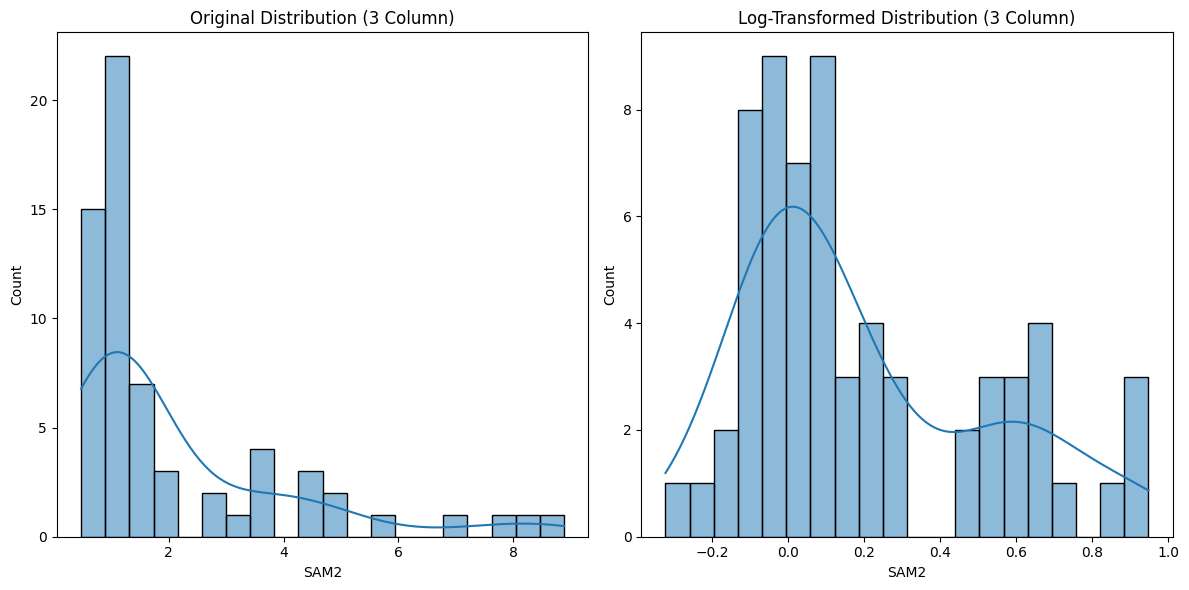

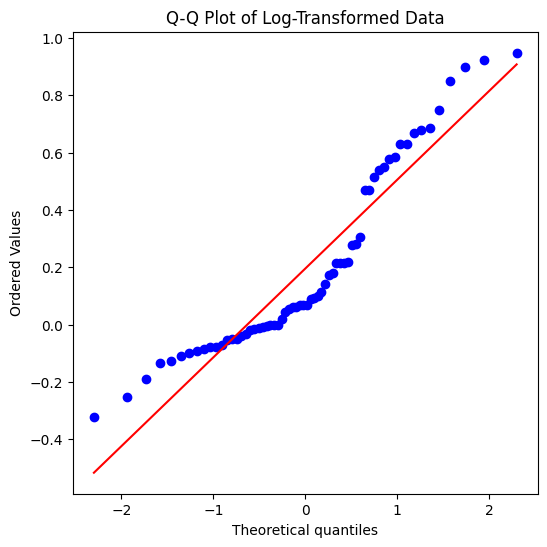

Shapiro-Wilk Test Statistic: 0.8954512793239591, p-value: 5.4152388346417353e-05
Anderson-Darling Test Statistic: 2.781954255707433
Critical Values: [0.545 0.621 0.745 0.869 1.034]
Significance Level: [15.  10.   5.   2.5  1. ]


In [6]:
column_id = 2  #change this to pick the index column

# Apply log transformation to the dataset (we'll ignore non-positive values)
log_transformed_df = np.log10(group_filled[group_filled > 0])

# Plot histograms of the original data and log-transformed data
plt.figure(figsize=(12, 6))

# Plot the original data's first column (for example)
plt.subplot(1, 2, 1)
sns.histplot(group_filled.iloc[:,column_id], kde=True, bins=20)
plt.title('Original Distribution ('+ str(column_id+1) +' Column)')

# Plot the log-transformed data
plt.subplot(1, 2, 2)
sns.histplot(log_transformed_df.iloc[:, column_id], kde=True, bins=20)
plt.title('Log-Transformed Distribution ('+ str(column_id+1) + ' Column)')

plt.tight_layout()
plt.show()

# Q-Q plot of the log-transformed data
import scipy.stats as stats
plt.figure(figsize=(6, 6))
stats.probplot(log_transformed_df.iloc[:, column_id], dist="norm", plot=plt)
plt.title('Q-Q Plot of Log-Transformed Data')
plt.show()

# Perform Shapiro-Wilk test for normality on log-transformed data (e.g., first column)
stat, p_value = shapiro(log_transformed_df.iloc[:, column_id].dropna())  # drop NaN values if any
print(f'Shapiro-Wilk Test Statistic: {stat}, p-value: {p_value}')

# Perform Anderson-Darling test for normality
result = anderson(log_transformed_df.iloc[:, column_id].dropna(), dist='norm')
print(f'Anderson-Darling Test Statistic: {result.statistic}')
print(f'Critical Values: {result.critical_values}')
print(f'Significance Level: {result.significance_level}')

# If p-value of Shapiro-Wilk is high, or Anderson-Darling statistic is below the critical value,
# the log-transformed data may be considered normally distributed, suggesting log-normal distribution.


Now for the unsupervised ML models. Since the above tests show the data is not log-normal. We have the option to transform our data log-normal which is standard practice, but perhaps the prev analysis indicates not enough measurements. The isolated code-block below can be used to log transform the dataset, and is optional. ( Overall it was found that this transformation has much affect on the current data)

In [5]:
#OPTIONAL use this block to log tranform data without affecting how the rest of the codw works

group_filled= np.log10(group_filled)

print(group_filled.shape)

(64, 44)


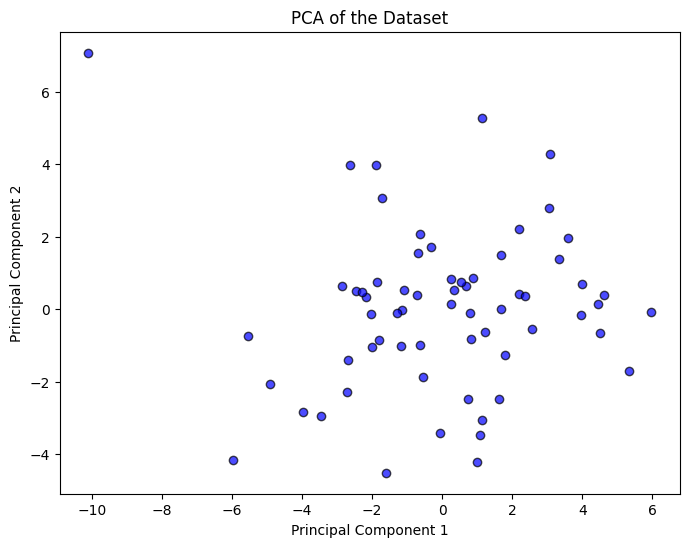

Explained variance ratio by PCA components: [0.19233707 0.11219961]


In [6]:
scaler= StandardScaler()
scaled_data = scaler.fit_transform(group_filled)


#apply PCA
pca = PCA (n_components =2) # you can change hyperparameter here.
 
pca_result = pca.fit_transform(scaled_data)


# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c='blue', edgecolor='k', alpha=0.7)
plt.title('PCA of the Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Print the explained variance ratio to understand how much variance each component explains
print(f"Explained variance ratio by PCA components: {pca.explained_variance_ratio_}")

In [8]:
# to add color of target metabolite total to the dimensional reduction

idx = df.groupby('UQ Strain')['Vanillate DAD_G 274nm_tot'].idxmax()
idxmax = df.loc[idx]
van_tot = idxmax['Vanillate DAD_G 274nm_tot'].values

print(van_tot.shape)
print(pca_result_df.shape)


(64,)


NameError: name 'pca_result_df' is not defined

In [9]:
# Plot the results

pca_result = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

pca_result['Van tot'] = van_tot


fig = px.scatter(pca_result, x='PC1', y='PC2', color='Van tot', title='PCA Results')
fig.show()

In [10]:
# Plot the results

pca_result_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

unique_strains = df['UQ Strain'].unique()
num_rows= len(pca_result_df)
if len(unique_strains)< num_rows:
    unique_strains = unique_strains*(num_rows//len(unique_strains)) + unique_strains[:num_rows%len(unique_strains)]
pca_result_df['Experiment'] = unique_strains[:num_rows]  # Add experiment labels

fig = px.scatter(pca_result_df, x='PC1', y='PC2', color='Experiment', title='PCA Results')
fig.show()

In [10]:
loadings = pca.components_.T #Transpose to match vraiables in rows (double check this to make sure it's correct)

#create a DataFrame for easier interpretation
loadings_df = pd.DataFrame(loadings,  index = group_filled.columns, columns=['PC1', 'PC2'])

print(loadings_df)

            PC1       PC2
SAH1  -0.129101 -0.073899
MET6  -0.069374  0.151766
SAM2  -0.140137 -0.055312
SAM1  -0.156667 -0.023363
ADOI  -0.104000  0.018638
SER3   0.259379  0.000824
SER1   0.264756  0.056271
SER2   0.258595  0.093560
SHM2   0.246435  0.075895
GCV1  -0.139186 -0.274270
GCV2  -0.152925 -0.159513
GCV3  -0.136501 -0.286649
LPD1  -0.158447 -0.141492
MET13 -0.044799 -0.160857
FDH1  -0.045577  0.015134
ADE3  -0.112012 -0.055930
MIS1   0.030641 -0.032442
SNZ1   0.223484  0.111827
MET7   0.073323 -0.188033
CBF1  -0.074374 -0.164883
CYS4  -0.141230  0.154420
CYS3  -0.204030  0.125328
HOM3   0.026068  0.205796
HOM2  -0.002003  0.321193
HOM6  -0.116567  0.326959
MET3  -0.263710  0.131864
MET14 -0.248959  0.166524
MET16 -0.232323  0.102913
MET10 -0.228428  0.209178
MET5  -0.255661  0.083257
MET2  -0.020109 -0.116107
MET17 -0.201915 -0.017971
CHO2   0.037004  0.031192
OPI3   0.160669  0.087106
GLY1  -0.043162  0.105207
FUM1   0.019721  0.121623
ICL1   0.170089 -0.000717
MAE1   0.040

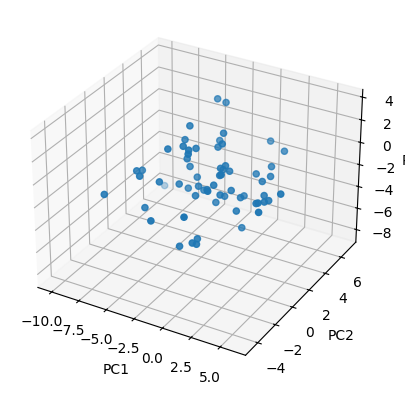

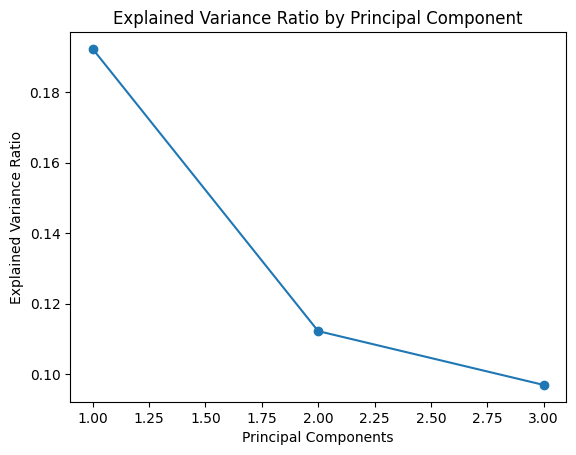

In [11]:
#apply PCA
pca = PCA (n_components =3) # you can change hyperparameter here.

pca_result = pca.fit_transform(scaled_data)

#pca_result = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()

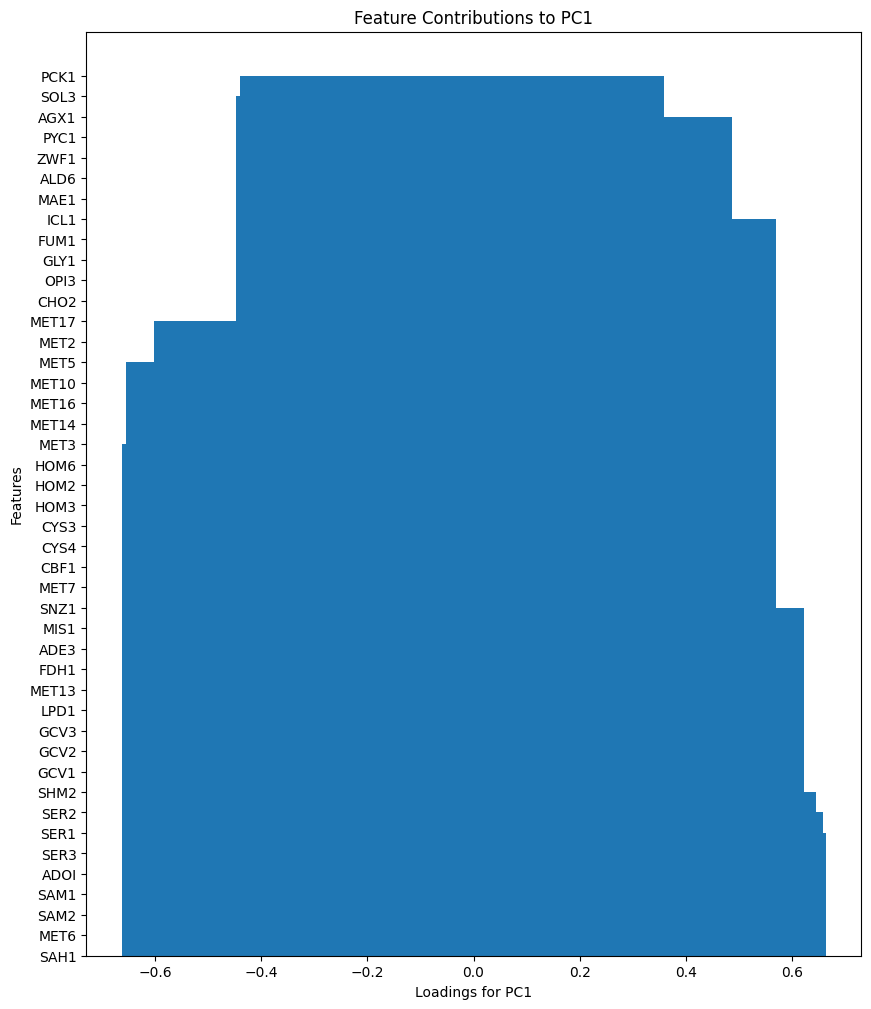

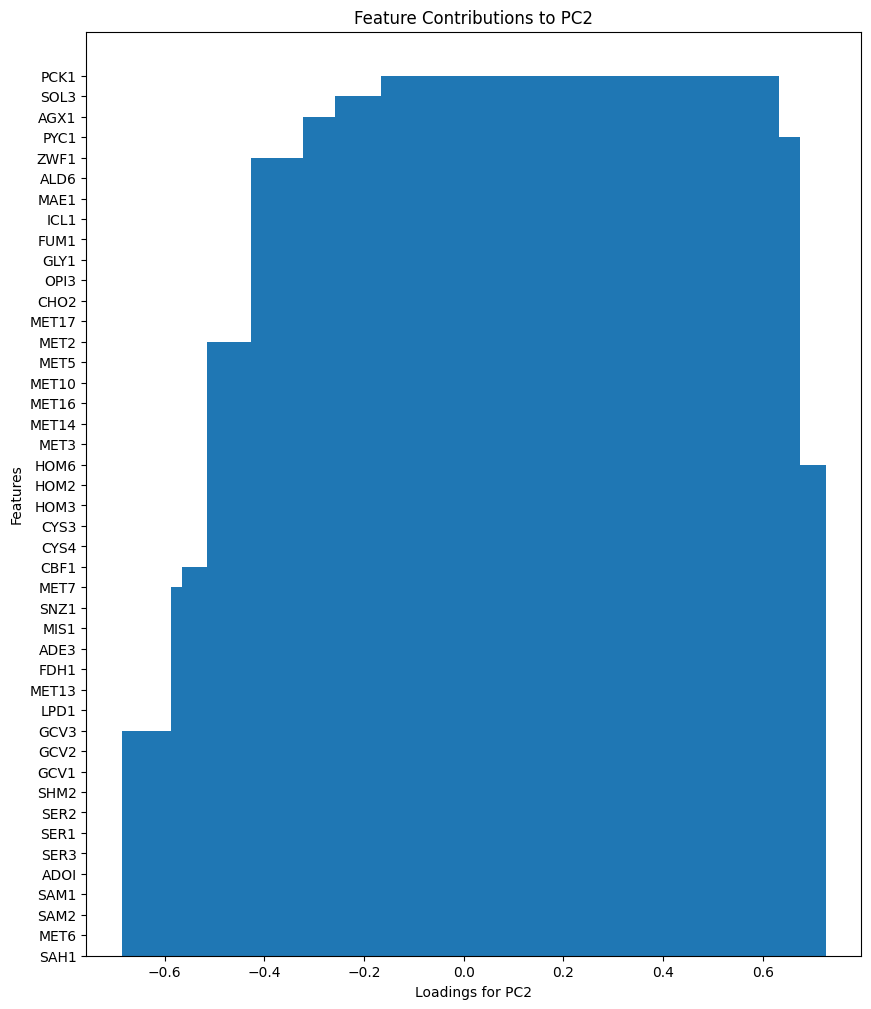

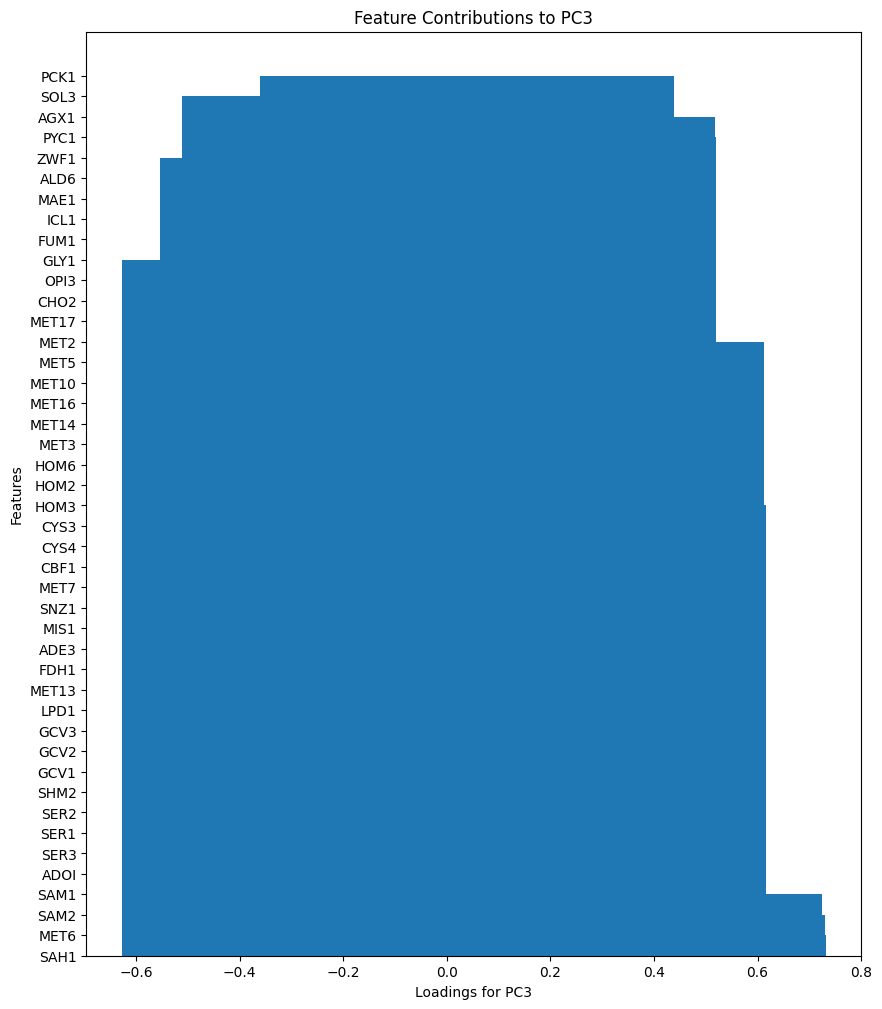

In [12]:
loadings = pca.components_  # Loadings matrix
loadings_df = pd.DataFrame(loadings, columns= group_filled.columns, index=[f'PC{i+1}' for i in range(loadings.shape[0])])

# Visualizing the loadings for PC1 and PC2
plt.figure(figsize=(10, 12))
plt.bar(loadings_df.iloc[0], loadings_df.columns)
plt.xlabel('Loadings for PC1')
plt.ylabel('Features')
plt.title('Feature Contributions to PC1')
plt.show()

plt.figure(figsize=(10, 12))
plt.bar(loadings_df.iloc[1], loadings_df.columns)
plt.xlabel('Loadings for PC2')
plt.ylabel('Features')
plt.title('Feature Contributions to PC2')
plt.show()

plt.figure(figsize=(10, 12))
plt.bar(loadings_df.iloc[2], loadings_df.columns)
plt.xlabel('Loadings for PC3')
plt.ylabel('Features')
plt.title('Feature Contributions to PC3')
plt.show()

In [13]:
from scipy.stats import zscore
z_score=np.abs(zscore(group_filled))
np.set_printoptions(threshold=np.inf, precision =6, suppress=True)
print(z_score)

top_3_indices = np.argsort(z_score, axis=None)[-3:]

# Retrieve the top 3 values using the indices
top_3_values = z_score.flatten()[top_3_indices]

print("Top 3 Z-scores:", top_3_values)

[[1.112836 0.574472 2.29715  2.320455 0.184566 1.292782 1.001213 1.371423
  0.992686 0.299884 0.511578 0.253352 0.230333 0.397007 0.086275 0.453942
  0.602542 0.938446 0.626863 0.101623 0.863206 0.098893 0.126298 0.287716
  0.193336 0.033035 0.117629 0.269659 0.27595  0.155887 0.327737 0.022042
  0.747772 0.994749 0.98576  0.045889 0.202793 0.112566 0.057351 0.168448
  0.627217 0.189852 0.547227 0.446488]
 [1.049248 0.782587 0.86663  0.557511 0.046765 0.199485 0.956654 1.079387
  0.709506 0.360078 0.338321 0.102199 0.393748 0.631995 0.34479  0.478998
  0.176164 0.574448 0.379585 2.547784 0.934516 0.715979 0.347566 0.487556
  1.352543 0.142726 0.056477 0.267138 0.5951   0.384884 0.549778 0.558376
  0.923736 1.10195  1.067495 0.743347 0.101304 0.059608 0.273697 0.007158
  0.374894 0.661022 0.675621 0.067676]
 [1.080189 0.431007 0.841268 0.705241 0.452951 2.846612 1.014019 0.8714
  0.510304 0.473144 0.314354 0.026353 0.142997 0.600457 0.661436 0.004509
  0.423776 0.754346 4.32599  0.25713

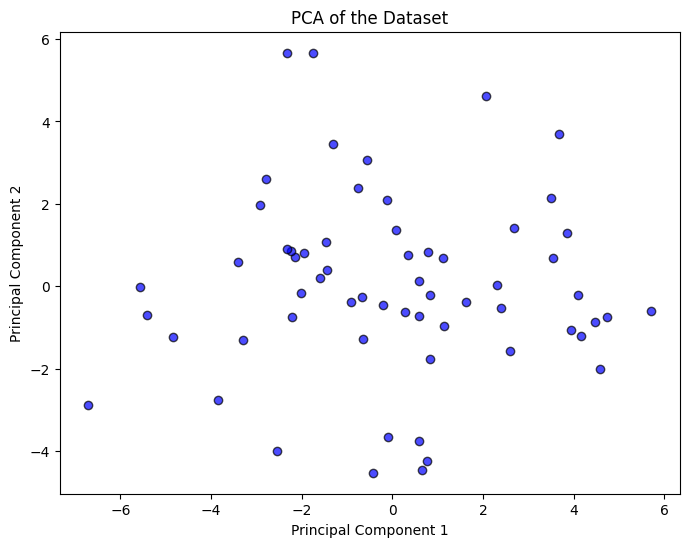

Explained variance ratio by PCA components: [0.200353 0.126126]


In [14]:
#Adjust how much outliers to remove threshold_value is z-score 
threshold_value = 6

#scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(group_filled)

from scipy.stats import zscore
z_scores = np.abs(zscore(scaled_data))  # Compute z-scores
data_no_outliers = scaled_data[(z_scores < threshold_value).all(axis=1)]  # Keep only rows with z-scores < threshold 


#apply PCA
pca = PCA (n_components =2) # you can change hyperparameter here.

pca_result = pca.fit_transform(data_no_outliers)


# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c='blue', edgecolor='k', alpha=0.7)
plt.title('PCA of the Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Print the explained variance ratio to understand how much variance each component explains
print(f"Explained variance ratio by PCA components: {pca.explained_variance_ratio_}")

In [15]:
pca_result_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

unique_strains = df['UQ Strain'].unique()
num_rows= len(pca_result_df)
if len(unique_strains)< num_rows:
    unique_strains = unique_strains*(num_rows//len(unique_strains)) + unique_strains[:num_rows%len(unique_strains)]
pca_result_df['Experiment'] = unique_strains[:num_rows]  # Add experiment labels


fig = px.scatter(pca_result_df, x='PC1', y='PC2', color='Experiment', title='PCA Results')
fig.show()

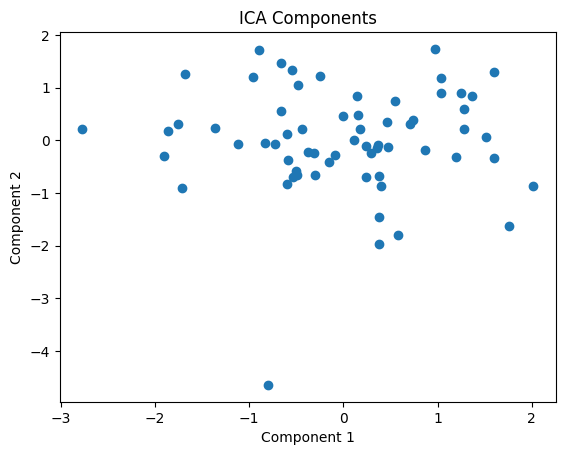

In [39]:
#scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(group_filled)
#scaled_data = scaler.fit_transform(data_no_outliers) #alternate version if you want to use no outliers (i had to change threshold value to 4 to show results below with better spread)


#apply ICA
ica = FastICA (n_components =2) # you can change hyperparameter here.
ica_result = ica.fit_transform(scaled_data)

#visualize the results
plt.scatter(ica_result[:,0], ica_result[:,1])#, c='blue', edgecolor='k', alpha=0.7)
plt.title('ICA Components')
plt.xlabel ('Component 1')
plt.ylabel ('Component 2')
plt.show()

In [40]:
ica_result_df = pd.DataFrame(ica_result, columns=['C1', 'C2'])

unique_strains = df['UQ Strain'].unique()
num_rows= len(ica_result_df)
if len(unique_strains)< num_rows:
    unique_strains = unique_strains*(num_rows//len(unique_strains)) + unique_strains[:num_rows%len(unique_strains)]
ica_result_df['Experiment'] = unique_strains[:num_rows]  # Add experiment labels


fig = px.scatter(ica_result_df, x='C1', y='C2', color='Experiment', title='ica Results')
fig.show()

In [44]:
# Plot the results

ica_result_van = pd.DataFrame(ica_result, columns=['IC1', 'IC2'])

ica_result_van['Van tot'] = van_tot


fig = px.scatter(ica_result_van, x='IC1', y='IC2', color='Van tot', title='ICA Results')
fig.show()

Let's extend the ica a bit further 

<Axes: >

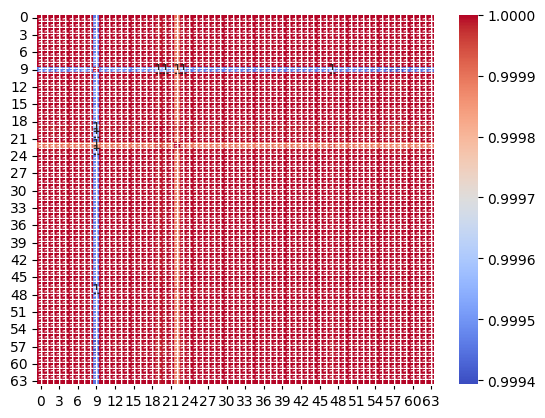

In [47]:
correlation_matrix = np.corrcoef(ica_result_van)  # Compute the correlation matrix of components
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

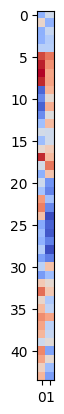

In [50]:
mixing_matrix = ica.mixing_  # Get the mixing matrix
plt.imshow(mixing_matrix, cmap='coolwarm')

In [55]:
# Didn't work yet

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(ica_result_van)
plt.scatter(ica_result_van[:, 0], ica_result_van[:, 1], c=kmeans.labels_)

InvalidIndexError: (slice(None, None, None), 0)

In [53]:
# didn't work yet

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(ica_result_van, van_tot)
importances = model.feature_importances_
plt.bar(range(len(importances)), importances)

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

c:\Users\uqkmuroi\.virtualenvs\ML_for_precision_fermentation-7MdyzI83\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\uqkmuroi\.virtualenvs\ML_for_precision_fermentation-7MdyzI83\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



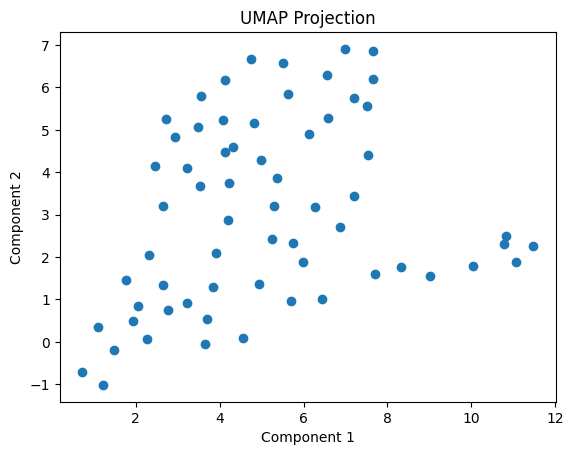

In [100]:
#scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(group_filled)

#this is gonna be a cheat, but I can't be bothered. We take the vanillate total max from each experiment from a separate file (already done) and use those instead of redoing with the current dataframe

df0 = pd.read_excel(r'C:\Users\uqkmuroi\Desktop\Gene or protein count data.xlsx')

idx = df.groupby('UQ Strain')['Vanillate DAD_G 274nm_tot'].idxmax()

df0=df0.loc[idx]
#print(df0)

label_van_tot = df0['Vanillate DAD_G 274nm_tot'].values


#print(label_van_tot)

# Apply UMAP
umap = U.UMAP(n_components=2, n_neighbors= 4, min_dist=0.6, random_state=42)  # Adjust n_components as needed (default is 2, 15, .1 I think)
umap_result = umap.fit_transform(scaled_data)  # Apply UMAP to your data

# Visualize the UMAP projection
plt.scatter(umap_result[:, 0], umap_result[:, 1])
plt.title('UMAP Projection')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

umap_df = pd.DataFrame(umap_result, columns = ['UMAP_1','UMAP_2'])


umap_df['van total']= label_van_tot

fig = px.scatter(umap_df, x='UMAP_1', y='UMAP_2', color='van total', title='UMAP Results')
fig.show()

In [22]:
print(group_filled.shape)

(64, 44)


c:\Users\uqkmuroi\.virtualenvs\ML_for_precision_fermentation-7MdyzI83\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\uqkmuroi\.virtualenvs\ML_for_precision_fermentation-7MdyzI83\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



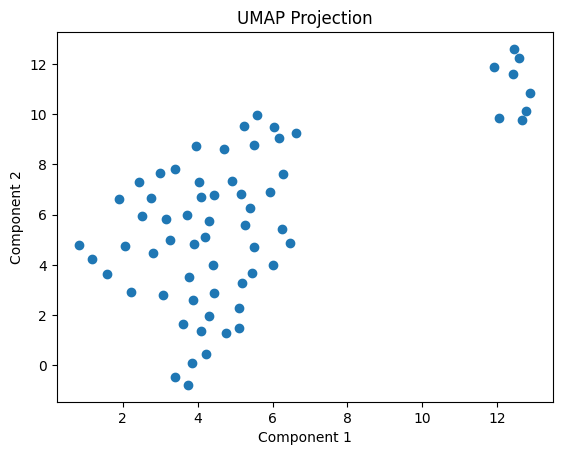

In [105]:
# the above code could be very  interesting to show connections with certain phenotypes, however, it seems that is does not work for vanillate, what if we try precursors or other measures

#adjust this code to aim for other precursor or target variables of interest and adjust hyperparameter of umap to see if there's patterns
idPrecursor = df.groupby('UQ Strain')['PCA DAD_H 302nm_tot'].idxmax()

dfPreMax=df.loc[idPrecursor]
#print(dfPreMax)

label_pca_tot = dfPreMax['PCA DAD_H 302nm_tot'].values


#print(label_pca_tot)

# Apply UMAP
umap = U.UMAP(n_components=2, n_neighbors= 3, min_dist=0.6, random_state=42)  # Adjust n_components as needed (default is 2, 15, .1 I think)
umap_result = umap.fit_transform(scaled_data)  # Apply UMAP to your data

# Visualize the UMAP projection
plt.scatter(umap_result[:, 0], umap_result[:, 1])
plt.title('UMAP Projection PCA 302nm')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

umap_df = pd.DataFrame(umap_result, columns = ['UMAP_1','UMAP_2'])


umap_df['pca tot']= label_pca_tot

fig = px.scatter(umap_df, x='UMAP_1', y='UMAP_2', color='pca tot', title='UMAP Results')
fig.show()

In [ ]:
umap_df = pd.DataFrame(umap_result, columns = ['UMAP_1','UMAP_2'])

label_experiment = group_filled.index
print(label_experiment)
print(label_experiment.shape)
umap_df['Experiment']= label_experiment


fig = px.scatter(umap_df, x='UMAP_1', y='UMAP_2', color='Experiment', title='UMAP Results PCA 302nm')
fig.show()

Index(['VAN_011', 'VAN_022', 'VAN_024', 'VAN_034', 'VAN_035', 'VAN_038',
       'VAN_039', 'VAN_040', 'VAN_053', 'VAN_054', 'VAN_059', 'VAN_063',
       'VAN_066', 'VAN_067', 'VAN_068', 'VAN_069', 'VAN_072', 'VAN_078',
       'VAN_079', 'VAN_080', 'VAN_083', 'VAN_086', 'VAN_090', 'VAN_091',
       'VAN_094', 'VAN_342', 'VAN_344', 'VAN_347', 'VAN_348', 'VAN_349',
       'VAN_351', 'VAN_352', 'VAN_353', 'VAN_354', 'VAN_355', 'VAN_356',
       'VAN_357', 'VAN_359', 'VAN_360', 'VAN_361', 'VAN_362', 'VAN_364',
       'VAN_365', 'VAN_366', 'VAN_369', 'VAN_371', 'VAN_373', 'VAN_374',
       'VAN_375', 'VAN_377', 'VAN_378', 'VAN_379', 'VAN_380', 'VAN_382',
       'VAN_383', 'VAN_386', 'VAN_387', 'VAN_388', 'VAN_389', 'VAN_391',
       'VAN_392', 'VAN_393', 'VAN_396', 'VAN_REF7'],
      dtype='object', name='UQ Strain')
(64,)


                           Base strain  Tkl1_counts  AroF_counts  AroB_counts  \
5                               Y64147            2            5            1   
11                              Y64147            2            5            1   
17                              Y64147            2            5            1   
23                              Y64147            2            5            1   
29                              Y64147            2            5            1   
..                                 ...          ...          ...          ...   
402  UQ Round 2 - Vanillate Design 045            2            5            1   
409  UQ Round 2 - Vanillate Design 025            2            5            1   
416                             Y64147            2            5            1   
423                             Y64147            2            5            1   
430                               Base            0            0            0   

     AroD_counts  AroZ_coun

In [73]:
print(umap_df)

       UMAP_1    UMAP_2    van total
0   19.186007  6.263169  4952.447068
1   17.512465  6.481120  1164.833526
2   18.296482  6.019146  2909.079446
3   16.774052  5.491991  3843.687074
4   16.832420  8.349294  4110.693695
..        ...       ...          ...
59  19.276585  8.147544  6482.053633
60  17.829302  8.847881  3669.222194
61  19.030300  7.750340  3693.414898
62  19.744812  7.642954  2958.085578
63  18.721369  7.503480  3192.759655

[64 rows x 3 columns]


This bit was suggested by Isabella for analysis

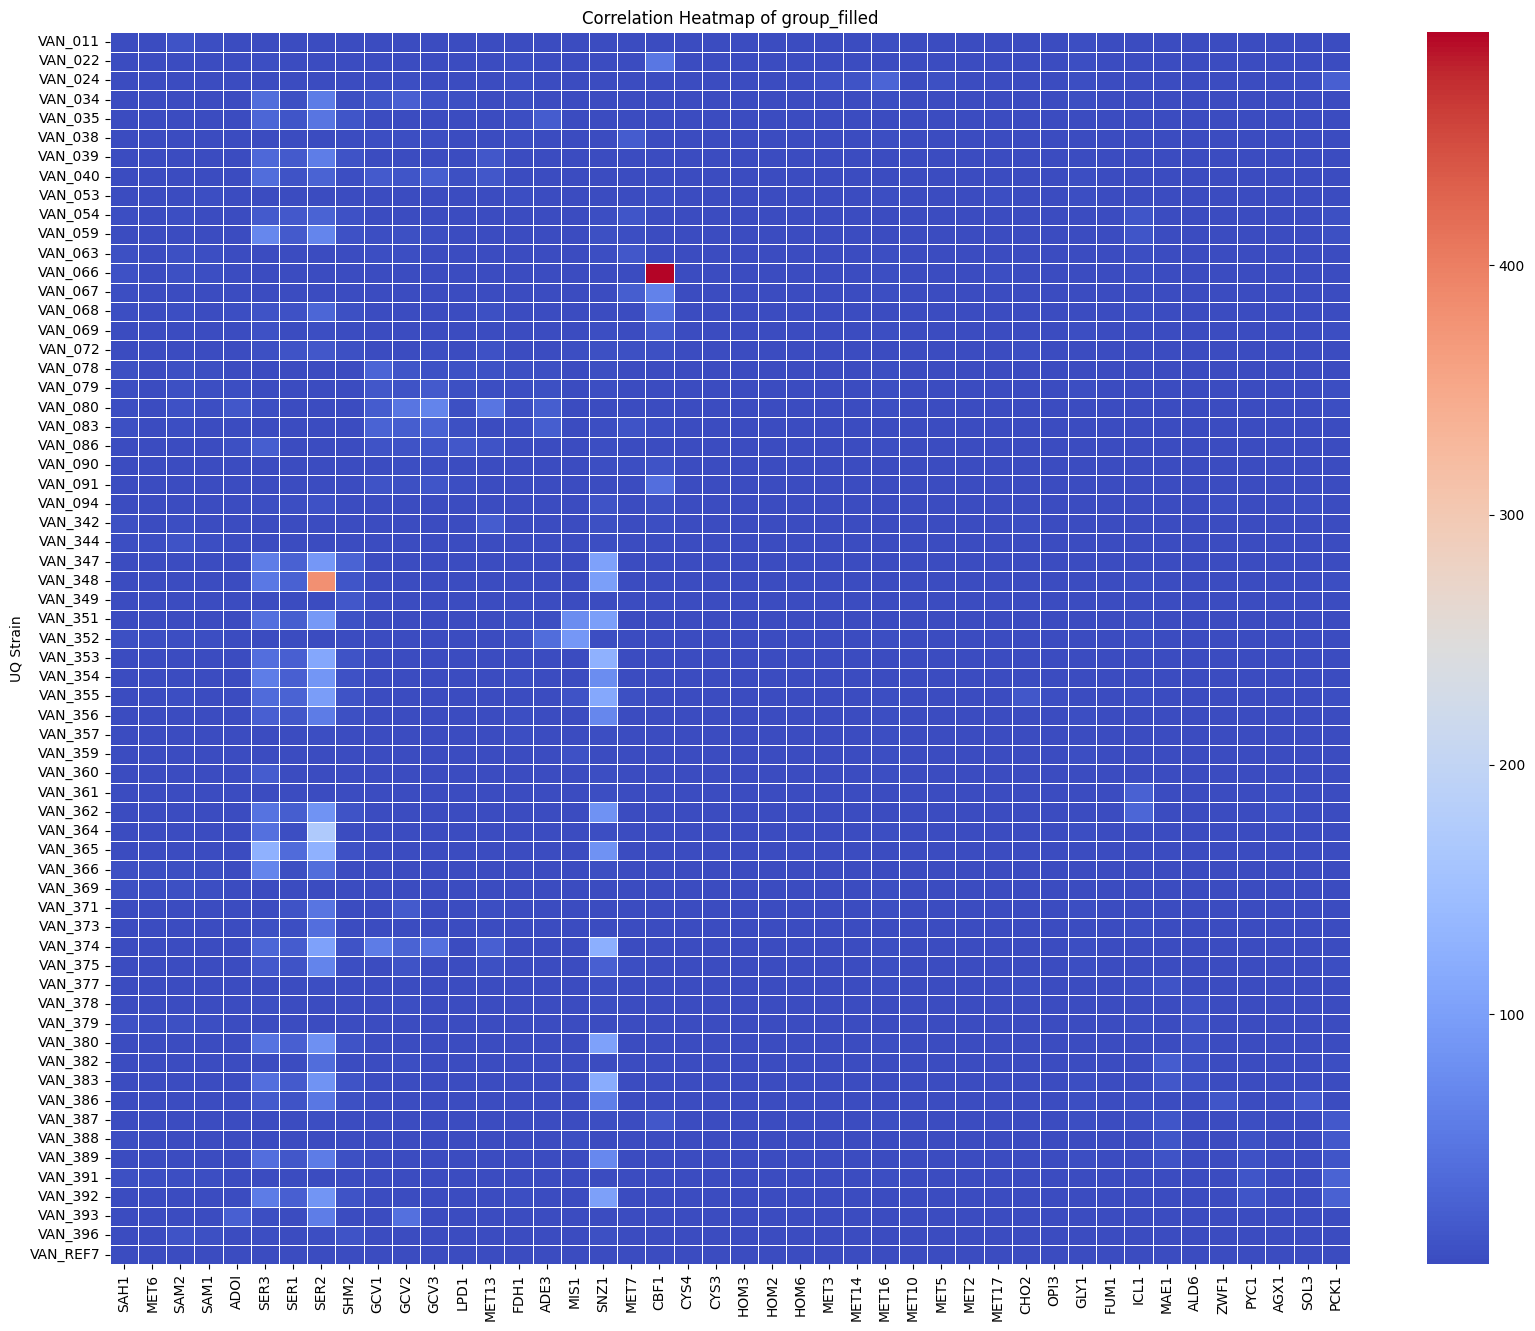

In [7]:
# this one changes quite a bit with log transform


import seaborn as sns
import matplotlib.pyplot as plt

log_filled = np.log10(group_filled)
# Assuming group_filled is your dataset (replace it with the actual variable if needed)
# Create a heatmap of the group_filled dataframe
plt.figure(figsize=(20, 16))  # You can adjust the size as needed
sns.heatmap(log_filled, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
#sns.heatmap(group_filled, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of group_filled')

# Show the plot
plt.show()

We also want to do a pls-da for this proteome dataset to compare with how it fared against the metabolomics dataset. Make sure to run the beginning section of the code to make sure group_filled variable is appropriately done before proceeding

In [62]:
target_data_threshold = 3000 # this is the separator between high and low of target metabolite


#scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(group_filled)

#since we've already grouped by UQ Straing, we just want the maximum from each group for Van total
grouped = df.groupby('UQ Strain')
target_data = grouped['Vanillate DAD_G 274nm_tot'].max()
print(target_data)

# it seems the discriminant analysis only works on classificiation data so let's split the van totals into high and low
y_binned = np.where(target_data > target_data_threshold, 1, 0) # 1 for high (values over 3000) and 0 for low.

print (y_binned)


UQ Strain
VAN_011     4952.447068
VAN_022     1164.833526
VAN_024     2909.079446
VAN_034     3843.687074
VAN_035     4110.693695
               ...     
VAN_391     6482.053633
VAN_392     3669.222194
VAN_393     3693.414898
VAN_396     2958.085578
VAN_REF7    3192.759655
Name: Vanillate DAD_G 274nm_tot, Length: 64, dtype: float64
[1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1]


In [63]:
pls= PLSRegression(n_components=2) # can change latent variable here

# apply pls regression
X_pls, y_pls = pls.fit_transform(scaled_data, y_binned)

# apply discriminant analysis (da) on the PLS components
lda = LinearDiscriminantAnalysis()
lda.fit(X_pls, y_binned)

# Now we want to show y_pred from lda
y_pred = lda.predict(X_pls)

#Evaluation
print("Classification Report:")
print(classification_report(y_binned, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_binned, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        44
           1       0.68      0.65      0.67        20

    accuracy                           0.80        64
   macro avg       0.76      0.76      0.76        64
weighted avg       0.79      0.80      0.80        64

Confusion Matrix:
[[38  6]
 [ 7 13]]


VIP scores for proteomics pls-da

Shape of X_scaled: (64, 44)
Shape of T (PLS scores): (64, 2)
Shape of W (PLS weights): (44, 2)
Shape of SS (sum of squares): (2,)
Normalized SS: [0.503182 0.496818]
Shape of VIP scores: (2,)
VIP scores shape is correct!


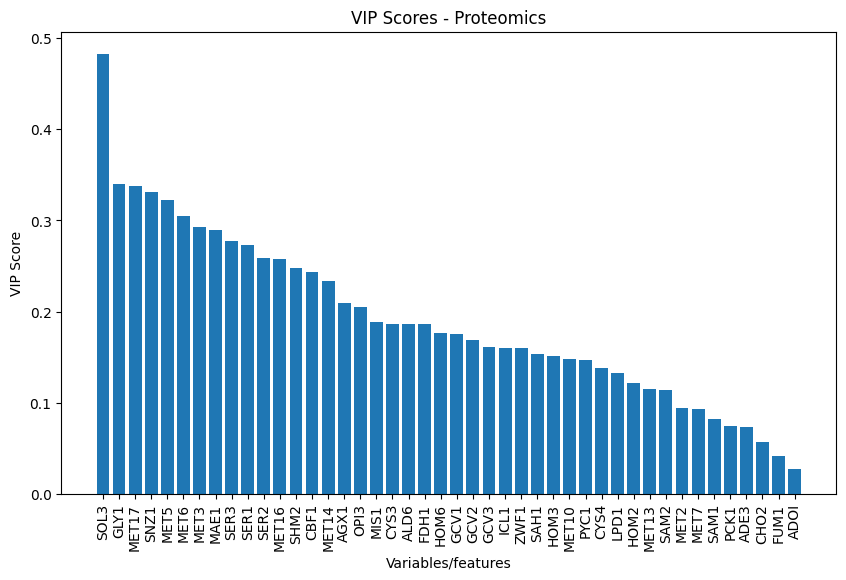

In [64]:
# Shape check: Ensure X_scaled is 2D (n_samples, n_features)
print(f"Shape of X_scaled: {scaled_data.shape}")


# Get the PLS components
T = pls.x_scores_  # PLS scores (latent variables)
W = pls.x_weights_  # PLS weights

# Shape check: Ensure T and W are 2D arrays
print(f"Shape of T (PLS scores): {T.shape}")
print(f"Shape of W (PLS weights): {W.shape}")

# Calculate the sum of squares for each component
SS = np.sum(T**2, axis=0)  # Sum of squares of the scores
print(f"Shape of SS (sum of squares): {SS.shape}")

# Normalize the sum of squares (if required)
SS = SS / np.sum(SS)  # Normalize to sum to 1
print(f"Normalized SS: {SS}")

# Compute the VIP scores
# VIP scores formula: sqrt(p * sum(W^2) * SS)
vip_scores = np.sqrt(scaled_data.shape[1] * np.sum(W**2, axis=0) * SS)
print(f"Shape of VIP scores: {vip_scores.shape}")

# correct the shape by summing over the compnents (axis=1) and multiply weights sqaured by normalized SS
vip_scores = np.sqrt(np.sum(W**2, axis=1) *np.sum(SS))

# Ensure VIP scores have the same length as the number of features
if vip_scores.shape[0] == scaled_data.shape[1]:
    print("VIP scores shape is correct!")
else:
    print("Error: VIP scores shape mismatch!")

group_filled_labels = group_filled.columns
# Sort the VIP scores in descending order and reorder the feature names accordingly
sorted_indices = np.argsort(vip_scores)[::-1]  # Indices of sorted VIP scores in descending order
sorted_vip_scores = vip_scores[sorted_indices]
sorted_feature_names = [group_filled_labels[i] for i in sorted_indices]

# Plot VIP scores
plt.figure(figsize=(10, 6))
plt.bar(range(scaled_data.shape[1]), sorted_vip_scores)
plt.xticks(range(scaled_data.shape[1]), sorted_feature_names, rotation=90)
plt.title('VIP Scores - Proteomics')
plt.xlabel('Variables/features')
plt.ylabel('VIP Score')
plt.show()


In [65]:
# vip seems to be incompatible with my current piplock so below does not work

from vip import vip

# Assuming pls_model is a fitted PLSRegression object and X is the feature matrix
vip_scores = vip(scaled_data, pls)

ModuleNotFoundError: No module named 'vip'